In [1]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_4_no_xyz/area_4/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Keys in the .mat file: ['Area_4']
Processing conferenceRoom_1...
Processing conferenceRoom_2...
Processing conferenceRoom_3...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing hallway_7...
Processing hallway_8...
Processing hallway_9...
Processing hallway_10...
Processing hallway_11...
Processing hallway_12...
Processing hallway_13...
Processing hallway_14...
Processing lobby_1...
Processing lobby_2...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing office_11...
Processing office_12...
Processing office_13...
Processing offic

In [2]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names)


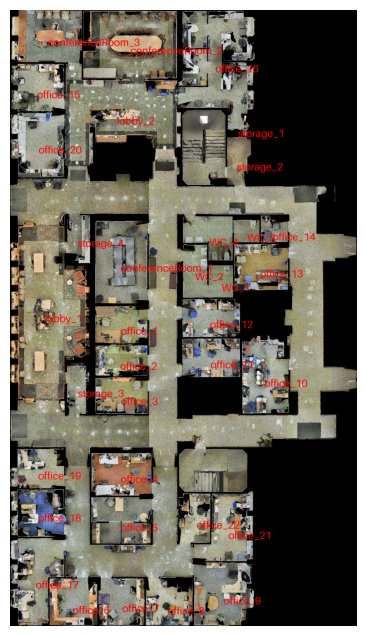

In [3]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

img = path_finding.write_scene_name(top_view_map, all_centers)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()

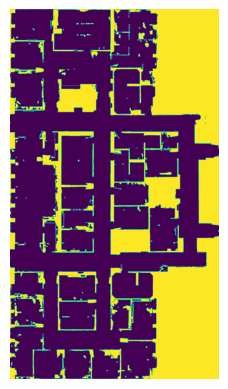

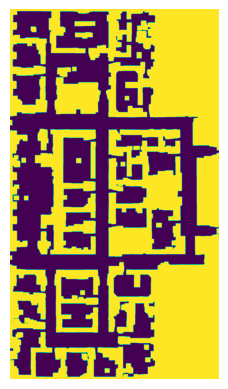

In [4]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25, 25))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [5]:
import numpy as np
import os
import pickle

# build topo map
# G = get_topologial_map(point_sum_points, scene_names)
# # graph_show(G)

# filename = "4"
# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

success load!


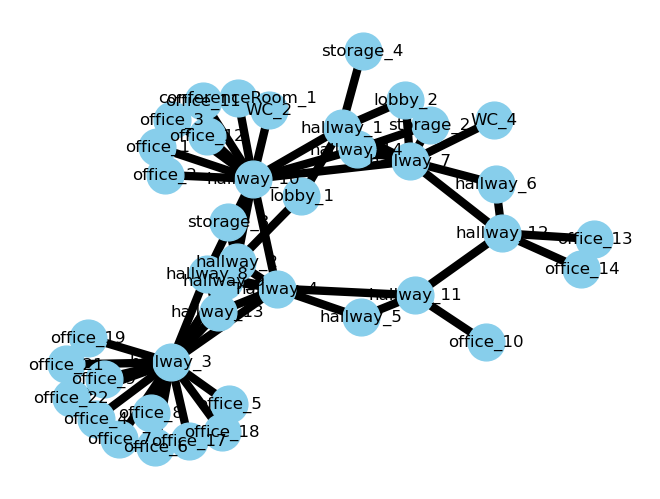

In [6]:

import numpy as np
import pickle

filename = "4"

# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

file_path = f"saved_maps/{filename}_arrays.npz"  
data = np.load(file_path, allow_pickle=True)
graph_serialized = data['graph'].item()
G_loaded = pickle.loads(graph_serialized)
print("success load!")

path_finding.graph_show(G_loaded)

In [7]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO

importlib.reload(path_finding)

def get_all_candidate_maps(source_node, target_node):
    
    file_path = f"saved_maps/{filename}_arrays.npz"  
    data = np.load(file_path, allow_pickle=True)
    graph_serialized = data['graph'].item()
    G_loaded = pickle.loads(graph_serialized)
    print("success load!")

    # G_loaded.remove_nodes_from(["hallway_8"])
    G_loaded.remove_edge('hallway_10', 'hallway_2')
    G_loaded.remove_edge('hallway_10', 'hallway_8')
    G_loaded.remove_edge('hallway_10', 'hallway_4')
    
    all_topo_paths = path_finding.get_all_simple_paths(G_loaded, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像
        
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [8]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    plt.imshow(evaluation_map)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print("value: ", sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

success load!
All paths from node office_4 to node office_14 :
4 ['office_4', 'hallway_4', 'hallway_11', 'office_14']
5 ['office_4', 'hallway_2', 'hallway_1', 'hallway_7', 'office_14']
5 ['office_4', 'hallway_9', 'hallway_10', 'hallway_7', 'office_14']
3
['office_4', 'hallway_4', 'hallway_11', 'office_14']
['office_4', 'hallway_2', 'hallway_1', 'hallway_7', 'office_14']
['office_4', 'hallway_9', 'hallway_10', 'hallway_7', 'office_14']


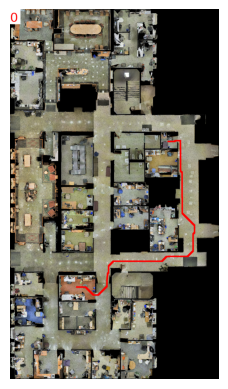

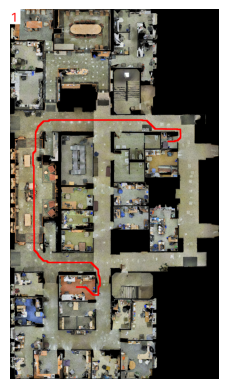

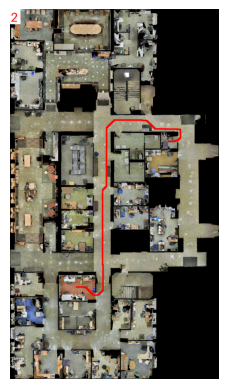

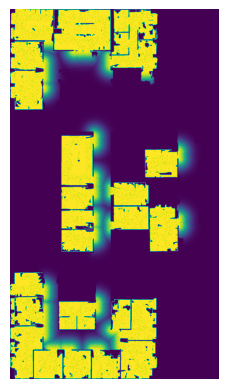

value:  221.07835651854194
distance:  1645
value:  38.03557860765611
distance:  2546
value:  251.96787561179946
distance:  1808
gpt-4o response: 
{
    "observation": "The task involves choosing the most secure and discreet path for transporting a secret file between offices. Three paths are available, each marked with a red line and numbered 0, 1, and 2.",
    "reason": "Path 0 is the most suitable for this task. It avoids high-traffic areas and minimizes exposure to multiple open office spaces, which is crucial for maintaining the secrecy of the file. Path 1 and Path 2, while similar in route, pass through more open office areas compared to Path 0, increasing the risk of accidental exposure of the secret file.",
    "self-critique": "While Path 0 is selected for its relative seclusion, it is slightly longer than the other paths, which could be seen as a disadvantage if speed were a priority. Additionally, the analysis assumes that fewer open office spaces directly correlate with high

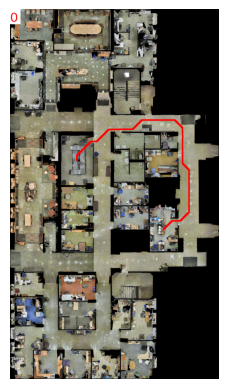

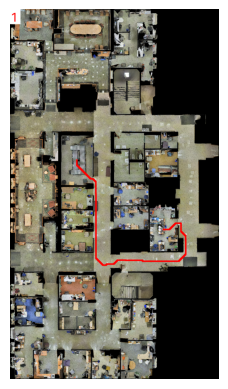

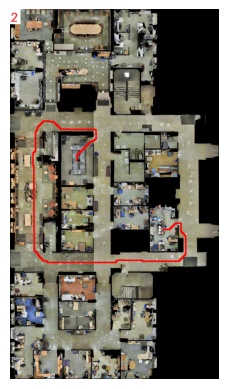

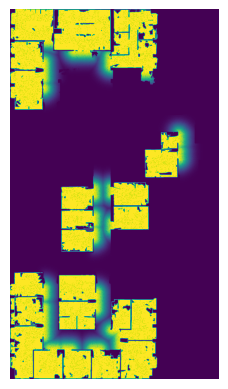

value:  206.34470509145066
distance:  1409
value:  363.62821439854616
distance:  1523
value:  0.6253310584893211
distance:  2656
gpt-4o response: 
{
    "observation": "The three paths provided (0, 1, and 2) each offer different routes from the office to the conference room. Path 0 takes a longer route around the perimeter, Path 1 takes a slightly shorter route but still avoids the central busy areas, and Path 2 takes the shortest route but passes through more populated office areas.",
    "reason": "For transporting fragile equipment, the primary concerns are minimizing the risk of accidental bumps or drops and avoiding high-traffic areas that could increase these risks. Path 0, while the longest, avoids most of the central, potentially busier office areas, providing a safer route for fragile equipment. Path 1, although shorter than Path 0, still passes close to several office areas which might be busy. Path 2, being the shortest, passes directly through multiple office areas, increas

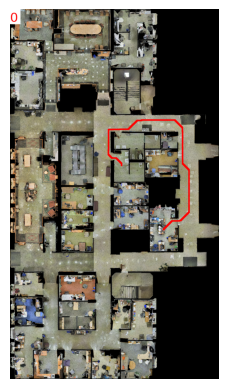

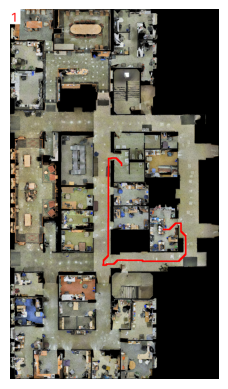

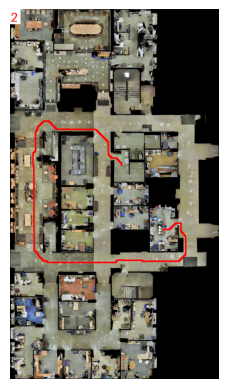

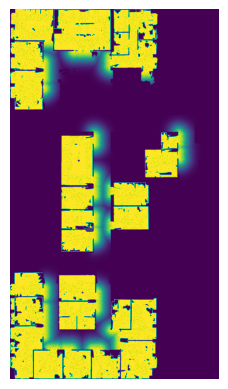

value:  225.62992793956352
distance:  1431
value:  241.73176947571164
distance:  1614
value:  76.04849028135722
distance:  2701
gpt-4o response: 
{
    "observation": "The task involves transporting a private medicine from an office to a bathroom. Three paths are provided, each with different routes through the office environment.",
    "reason": "Path 1 is selected as the optimal route for transporting the private medicine. This path avoids high-traffic areas and minimizes exposure to multiple office spaces, which is crucial for maintaining privacy. Path 0 and Path 2, although viable, pass through more populated and open office areas, potentially compromising the privacy of the medicine being transported.",
    "self-critique": "While Path 1 is the most private among the options, it is not the shortest route, which could be seen as a drawback if speed were a priority. Additionally, the analysis could be enhanced by more specific information on the typical occupancy or busyness of the 

In [9]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a secret file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"

source_nodes = ["office_4", "office_10", "office_10"]
target_nodes = ["office_14", "conferenceRoom_1", "WC_2"]


total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = ast.literal_eval(response_message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    responses = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
        for future in concurrent.futures.as_completed(future_to_message):
            prompt = future_to_message[future]
            try:
                response = future.result()
                responses.append(response)
            except Exception as exc:
                print(f'{prompt} generated an exception: {exc}')

    id_list = []
    for i, response in enumerate(responses):
        ground_json = ast.literal_eval(response)
        id_list.append(int(ground_json["path_id"])) 
    print(id_list)
            
    counter = Counter(id_list)

    index, count = counter.most_common(1)[0]
    print("select ", index)
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)